In [1]:
import awkward as ak
import numpy as np
import uproot as uproot
import h5py

In [2]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.style.use('../plots/ssdjet.mplstyle')

In [13]:
# List ROOT files

#! ls /eos/cms/store/group/ml/AnomalyHackathon/SUEP/scouting/SUEP_125_htcut/*root
#! ls /eos/cms/store/group/ml/AnomalyHackathon/SUEP/scouting/QCD_15to7000_htcut/*root

In [4]:
# Pick a file

file = uproot.open('{}{}'.format(
    '/eos/cms/store/group/ml/AnomalyHackathon/SUEP/scouting/SUEP_125_htcut/',
    'flat_step3_mMed-125_mDark-2_temp-2_decay-darkPhoHad_n-200_1000598_numEvent100000000.root'))

In [5]:
# Collect data

events = file['mmtree/tree']
nEvents = 200
HT_THRESHOLD = 500
pts = events['PFcand_pt'].array(entry_stop=nEvents)
mass = events['PFcand_m'].array(entry_stop=nEvents)
phis = events['PFcand_phi'].array(entry_stop=nEvents)
etas = events['PFcand_eta'].array(entry_stop=nEvents)
values = events['PFcand_pt'].array(entry_stop=nEvents)
is_suep = events['PFcand_fromsuep'].array(entry_stop=nEvents)
ht = events['ht'].array(entry_stop=nEvents)
n_fatjet = events['n_fatjet'].array(entry_stop=nEvents)
fatjet_eta = events['FatJet_eta'].array(entry_stop=nEvents)
fatjet_phi = events['FatJet_phi'].array(entry_stop=nEvents)
fatjet_mass = events['FatJet_mass'].array(entry_stop=nEvents)
fatjet_pt = events['FatJet_pt'].array(entry_stop=nEvents)

In [6]:
# Fix dummy edges

edges_eta = np.linspace(-2.5,2.5,281)
edges_phi = np.linspace(-np.pi,np.pi,361)

In [7]:
def get_energy_map(etas, phis, values):
    """Translate eta/phi to pixel coordinates"""
    
    img, _, _ = np.histogram2d(etas,
                               phis,
                               bins=[edges_eta, edges_phi],
                               weights=values)
    bins = np.argwhere(img)
    indices_eta = bins[:, 0]
    indices_phi = bins[:, 1]
    values = img[indices_eta, indices_phi]
    return indices_eta, indices_phi, values, img

In [8]:
def get_jet_labels(etas, phis, pts, mass, label):
    """Returns labels for jets"""
    coordinates = []
    for e, p, pt, m in zip(etas, phis, pts, mass):
        x = np.argmax(edges_eta >= e)
        y = np.argmax(edges_phi >= p)
        if label and x > label[0] and x < label[2] and y > label[1] and y < label [3]:
            continue
        coordinates.append((x, y, pt, m))
    return coordinates

In [9]:
def get_suep_label(etas, phis, pts, mass, flags):
    """Returns labels for suep"""

    pt = sum(pts[flags])
    if pt == 0:
        return None
    m = sum(mass[flags])
    e = etas[flags]
    p = phis[flags]
    p_alt = [i+np.pi if i < 0 else i-np.pi for i in p]

    xmin = np.argmax(edges_eta >= min(e))
    xmax = np.argmax(edges_eta >= max(e))

    ymin1 = np.argmax(edges_phi >= min(p))
    ymax1 = np.argmax(edges_phi >= max(p))

    ymin2 = np.argmax(edges_phi >= min(p_alt))
    ymax2 = np.argmax(edges_phi >= max(p_alt))

    if abs(ymax2-ymin2)<abs(ymax1-ymin1):
        if abs(ymin2-180)<abs(ymax2-180):
            return xmin, ymin2-180, xmax, ymax2-180, pt, m
        return xmin, ymin2+180, xmax, ymax2+180, pt, m
    return xmin, ymin1, xmax, ymax1, pt, m

In [10]:
def show_image(deposits, suep, jets):
    """Draws event in color"""
    offset = 15
    fig = plt.figure(figsize=(14.0, 10.0))
    ax = plt.subplot()
    ax.set_xlim([-offset, deposits.shape[1]+offset])
    ax.set_xlabel('$\eta$', horizontalalignment='right', x=1.0)
    ax.set_ylim([-offset, deposits.shape[0]+offset])
    ax.set_ylabel('$\phi [\degree$]', horizontalalignment='right', y=1.0)
    ax.imshow(deposits)

    # SUEP Box
    if suep:
        s = patches.Rectangle((suep[0], suep[1]),
                                suep[2]-suep[0],
                                suep[3]-suep[1],
                                linewidth=2,
                                edgecolor='red',
                                facecolor='none')
        ax.add_patch(s)
        ax.text(suep[0], suep[3],
                'SUEP, m={:.1f}, pt={:.1f}'.format(suep[-1],suep[-2]),
                color='#FAFAFA',
                bbox={'facecolor': 'red', 'alpha': 1.0})
    # Jet box
    for j in jets:
        s = patches.Rectangle((j[0]-23, j[1]-23),
                               46,
                               46,
                               linewidth=2,
                               edgecolor='white',
                               facecolor='none')
        ax.add_patch(s)
        ax.text(j[0]-23, j[1]+23,
            'Jet, m={:.1f}, pt={:.1f}'.format(j[-1],j[-2]),
            color='black',
            bbox={'facecolor': 'white', 'alpha': 1.0})
    plt.show()

In [11]:
def plotEtaPhi(eta, phi, energy, from_suep, visualizeEnergy):
    '''
        Helper function to plot the points in the (\eta,\phi) plane.
        The points belonging to the same class (SUEP, QCD) are colored with the same color.
        eta : Points \eta 
        phi : Points \phi positions 
        energy: Points Energies 
        from_suep: Is the particle matched to a generator-level SUEP decay product (R<0.03)
        eventToVisualize: Event you want to visualize, integer.
        visualizeEnergy: Marker size proportional to point energy, bool
    '''
    colors = []
    for i in from_suep:
        if i == True:
            colors.append('indianred')
        else:
            colors.append('cornflowerblue')
    fig = plt.figure(figsize=(7.8, 10.0))
    ax = plt.subplot()
    ax.set_xlim([-2.6,2.6])
    ax.set_xlabel('$\eta$', horizontalalignment='right', x=1.0)
    ax.set_ylim([-3.28,3.28])
    ax.set_ylabel('$\phi [\degree$]', horizontalalignment='right', y=1.0)
    ax.scatter(eta, phi, s = energy*10,  c = colors, alpha = .5 ) 
    plt.show()

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman


Event 1, ht=681.53
[0.483, 0.0484, 0.0232, 0.0475, 1.19, 1.74, ... 1.67, 0.966, 1.81, -1.95, -1.03]


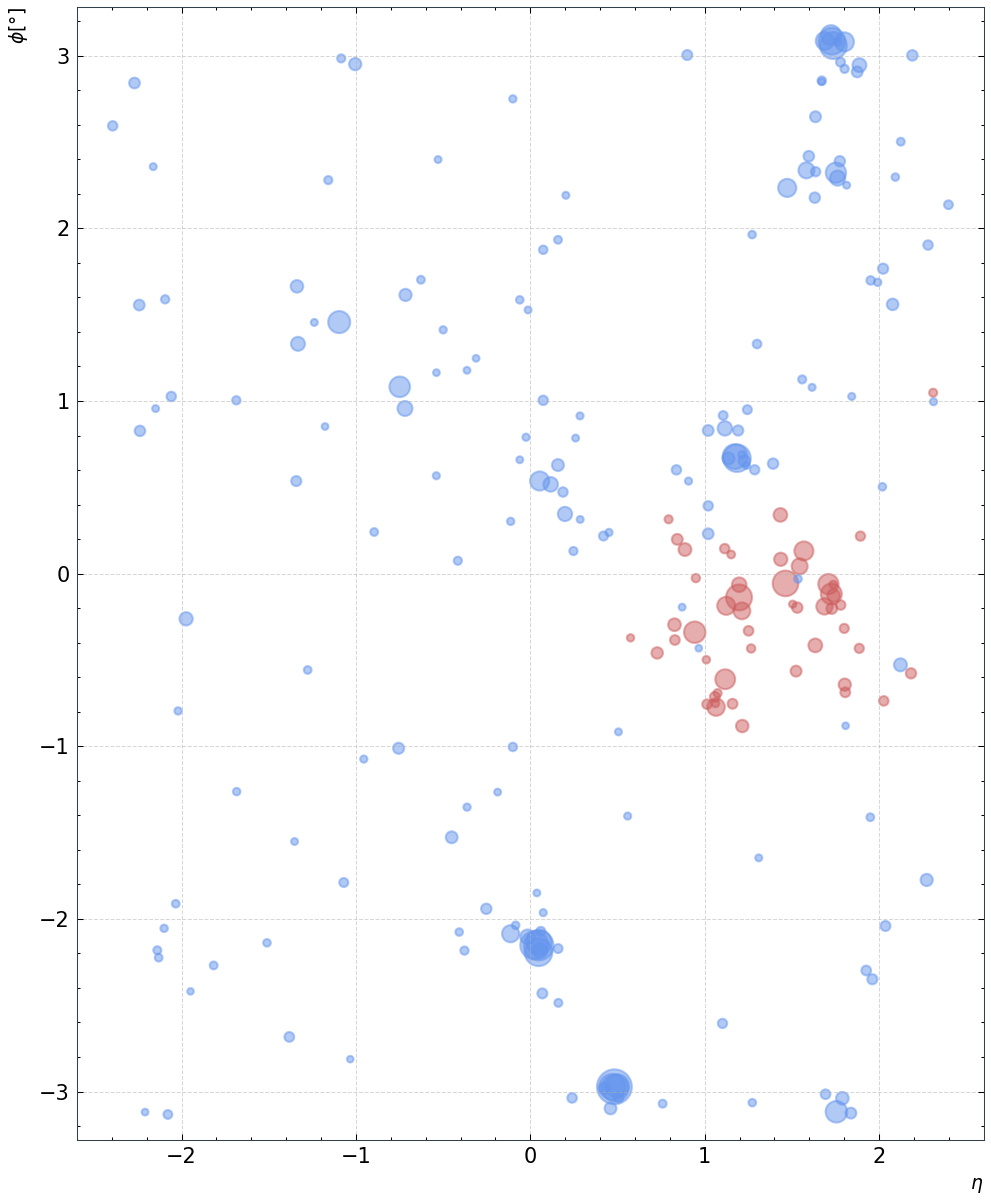

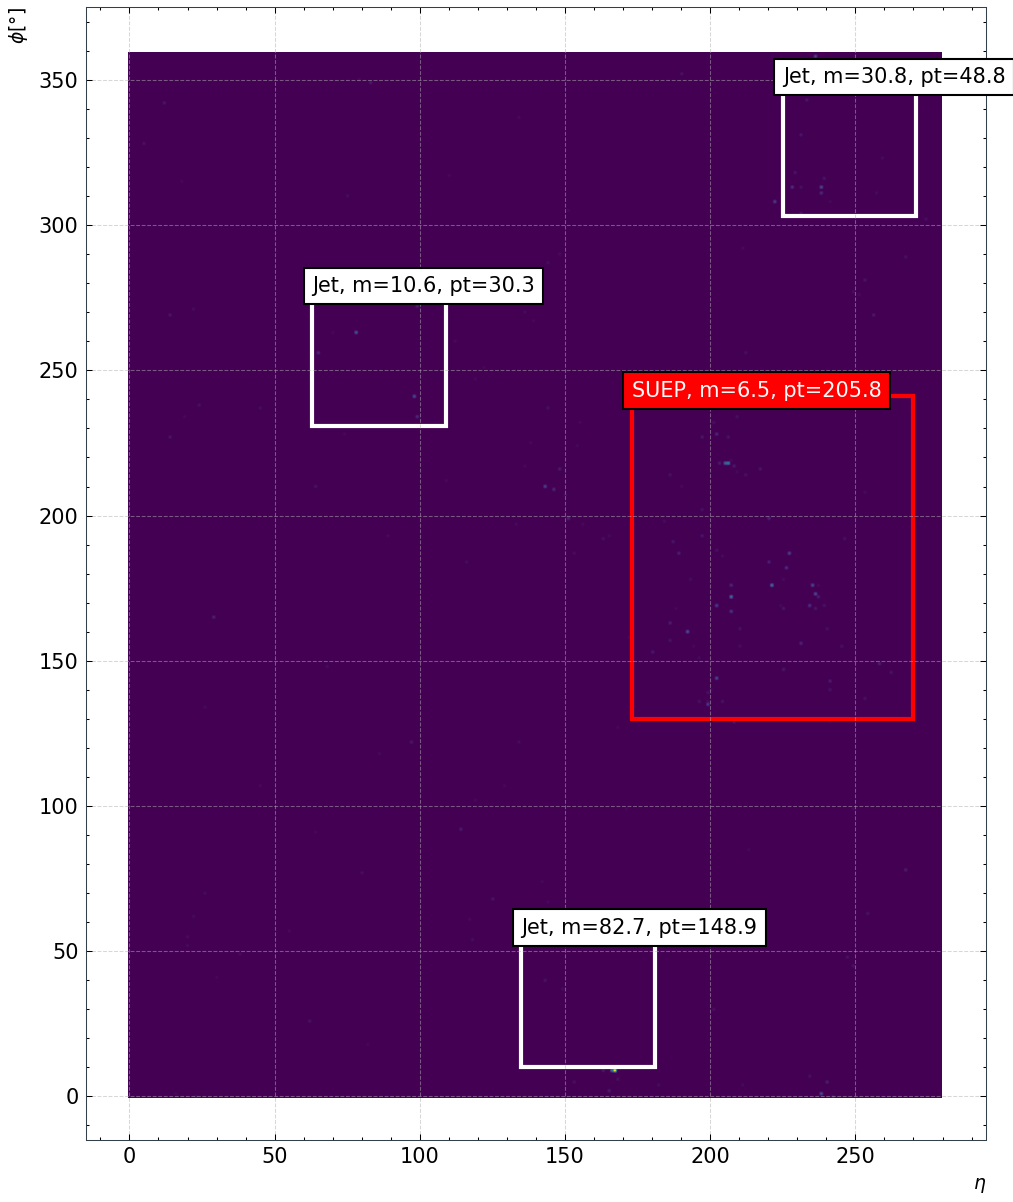

Event 2, ht=590.13
[2.18, 2.18, 2.18, 0.143, 0.251, 0.521, ... 2.03, -1.82, 0.188, -0.432, 0.0408]


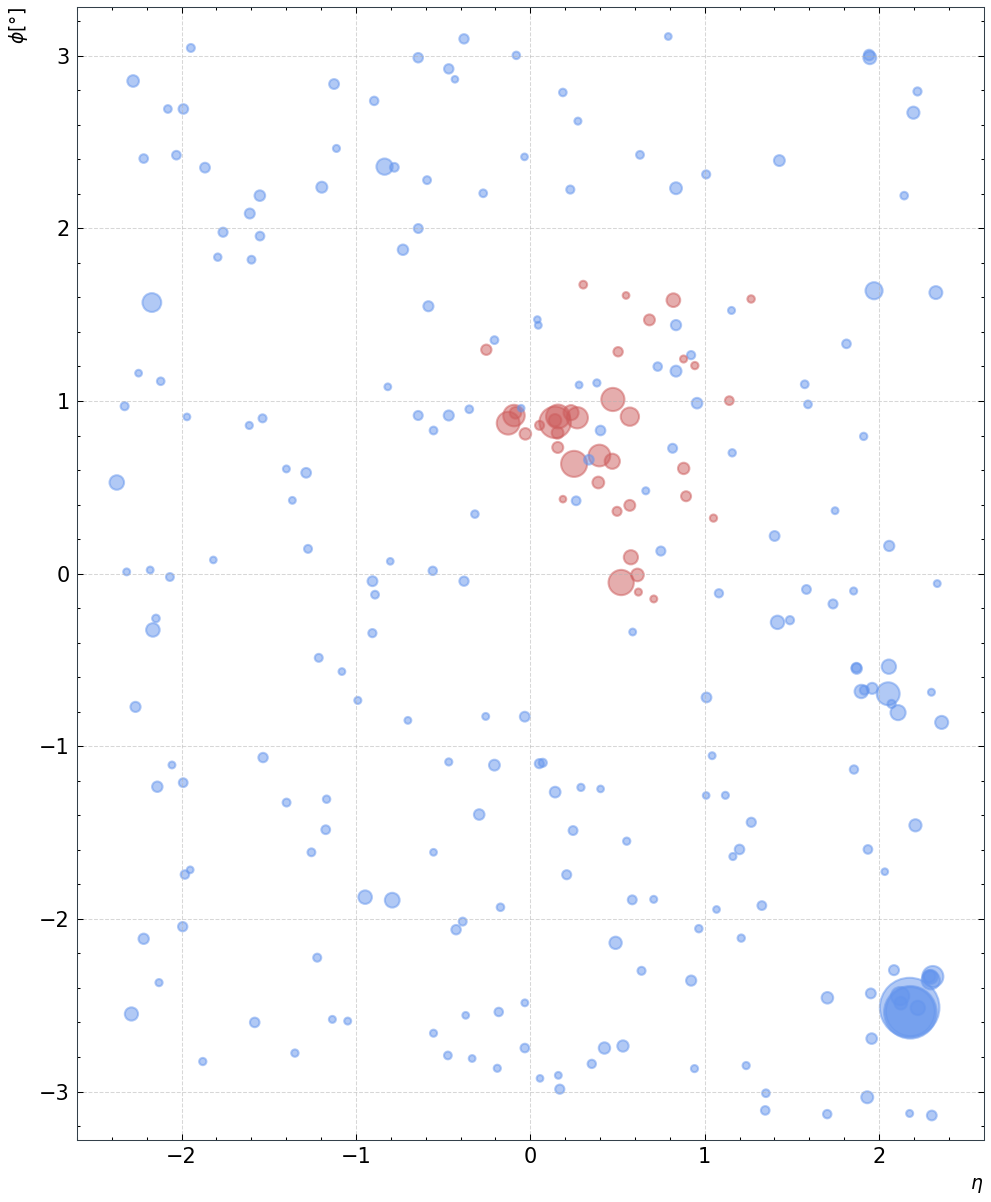

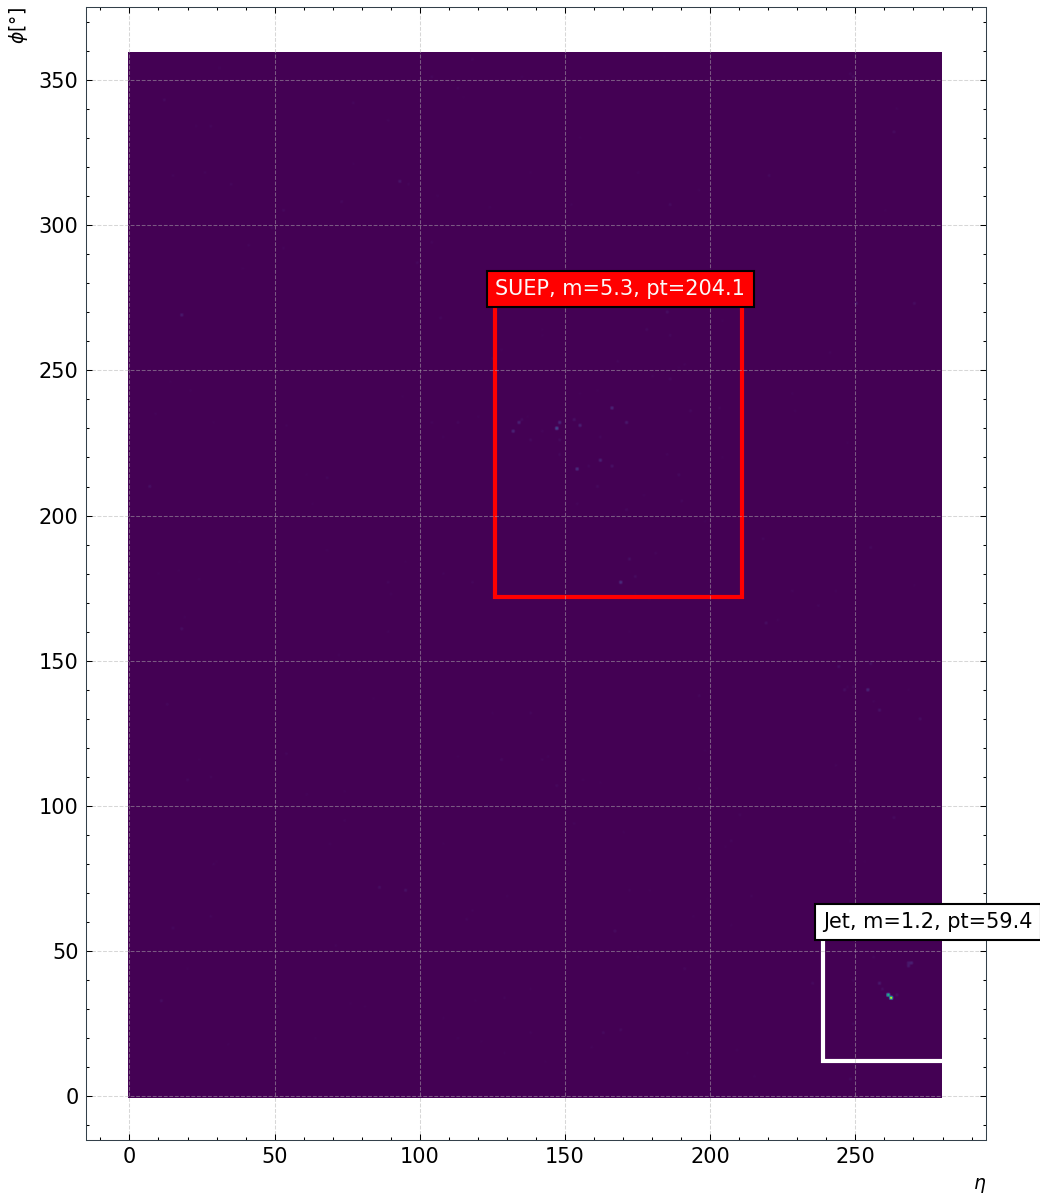

Event 3, ht=1906.02
[1.15, 1.75, 0.554, 0.432, 0.394, 0.602, ... -1.11, 1.24, -0.129, 2.11, 0.0451]


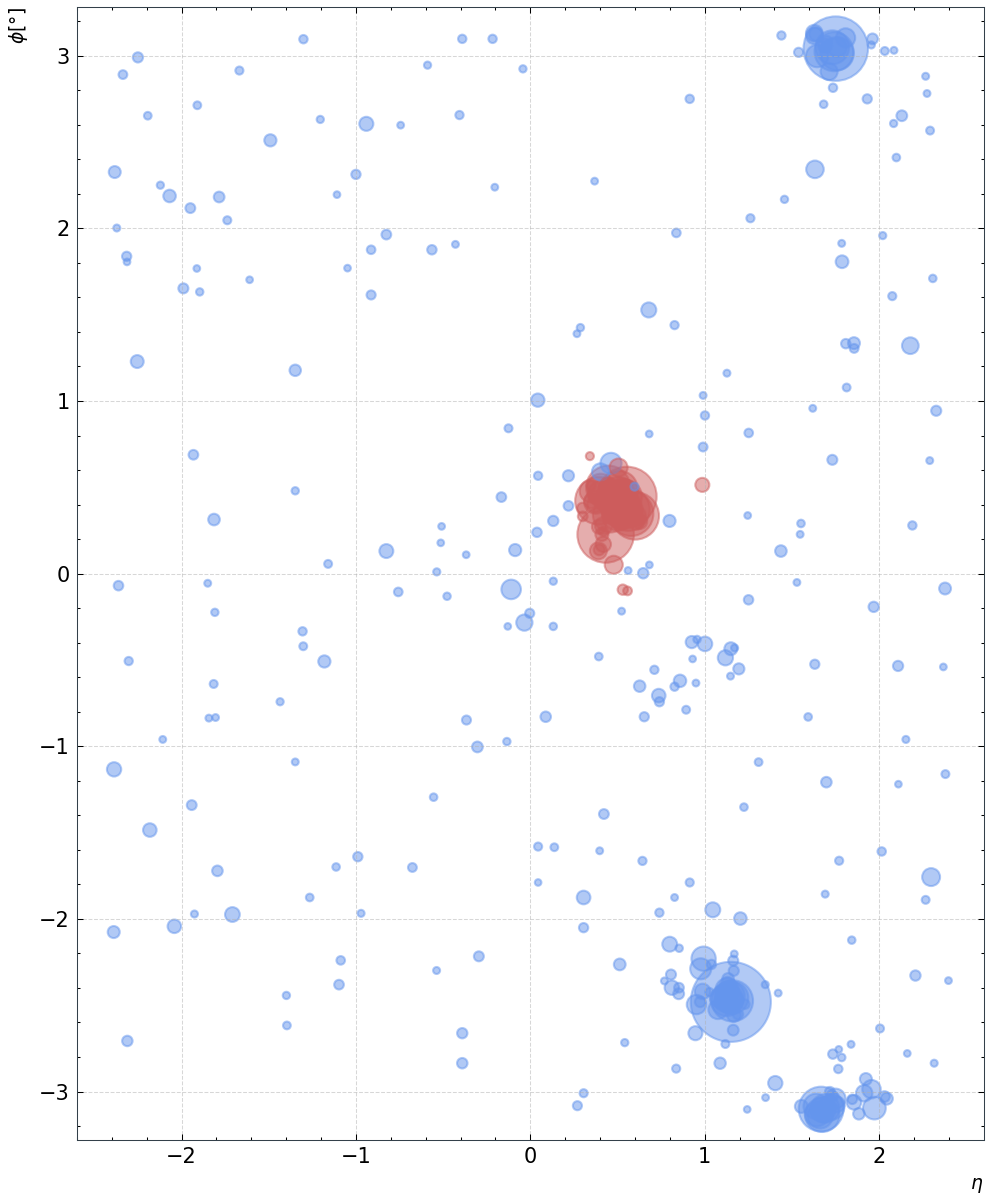

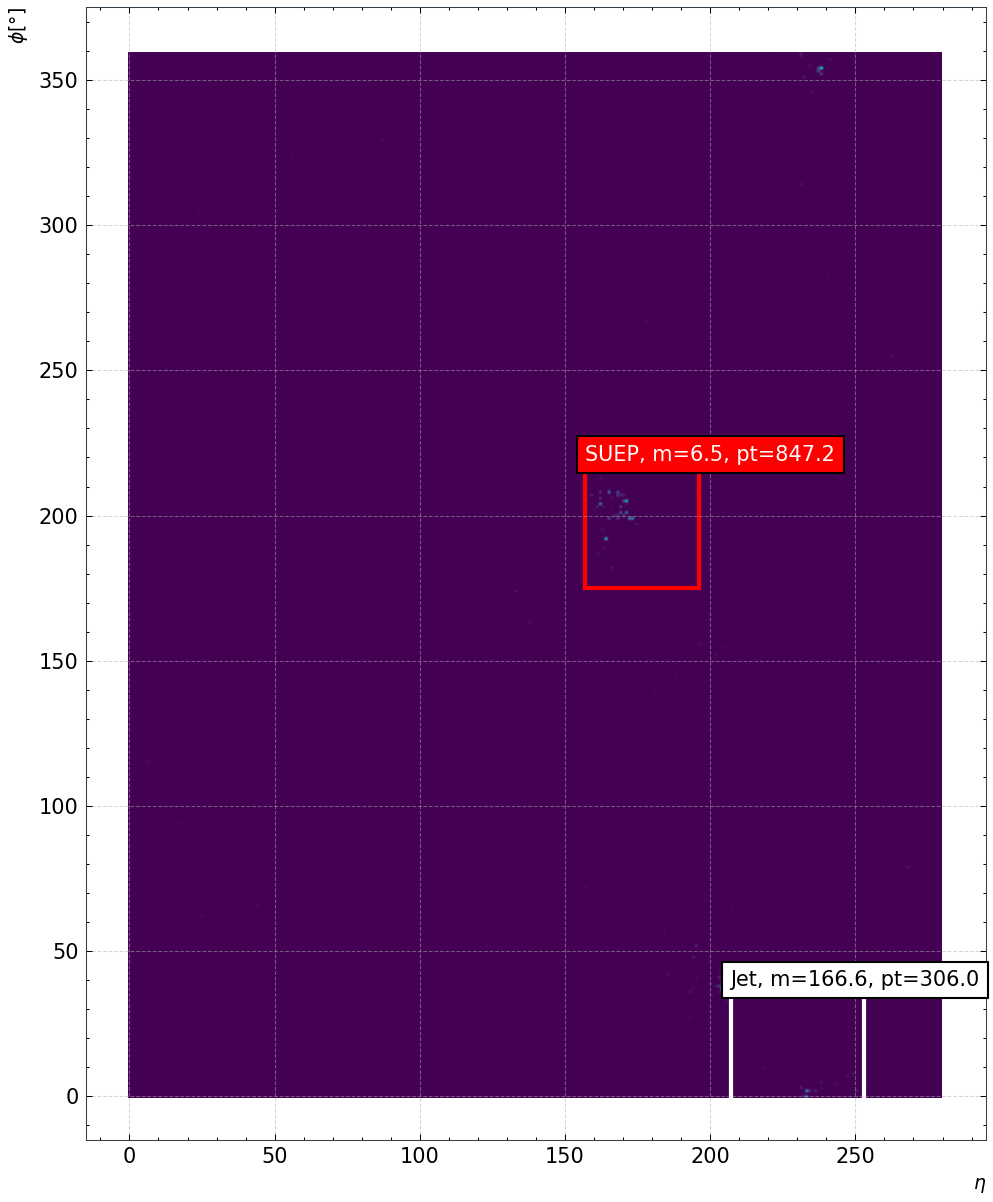

Event 4, ht=616.37
[-0.744, -0.681, -0.767, -0.659, -0.759, ... 0.86, -0.565, 0.973, 1.95, -0.818]


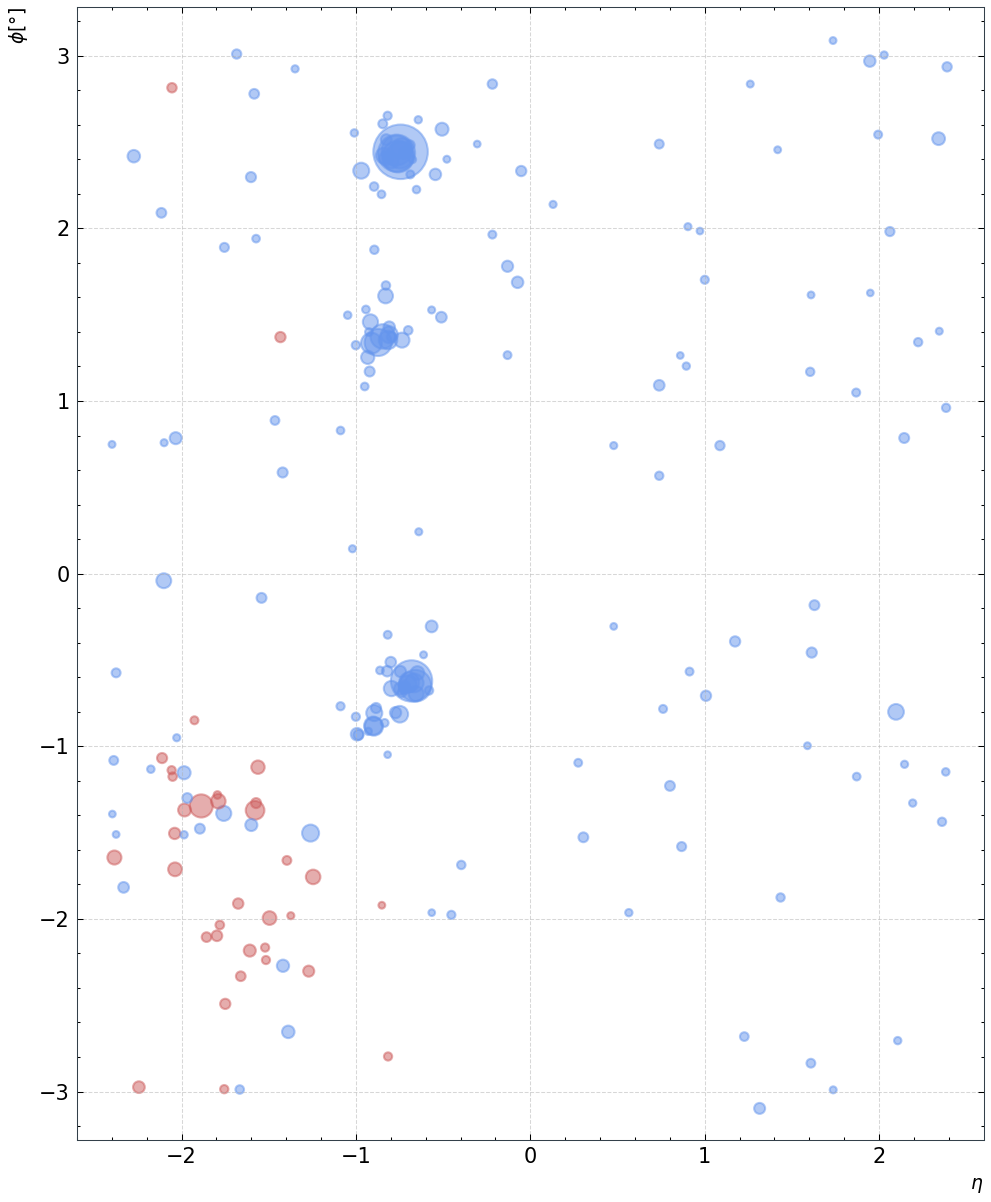

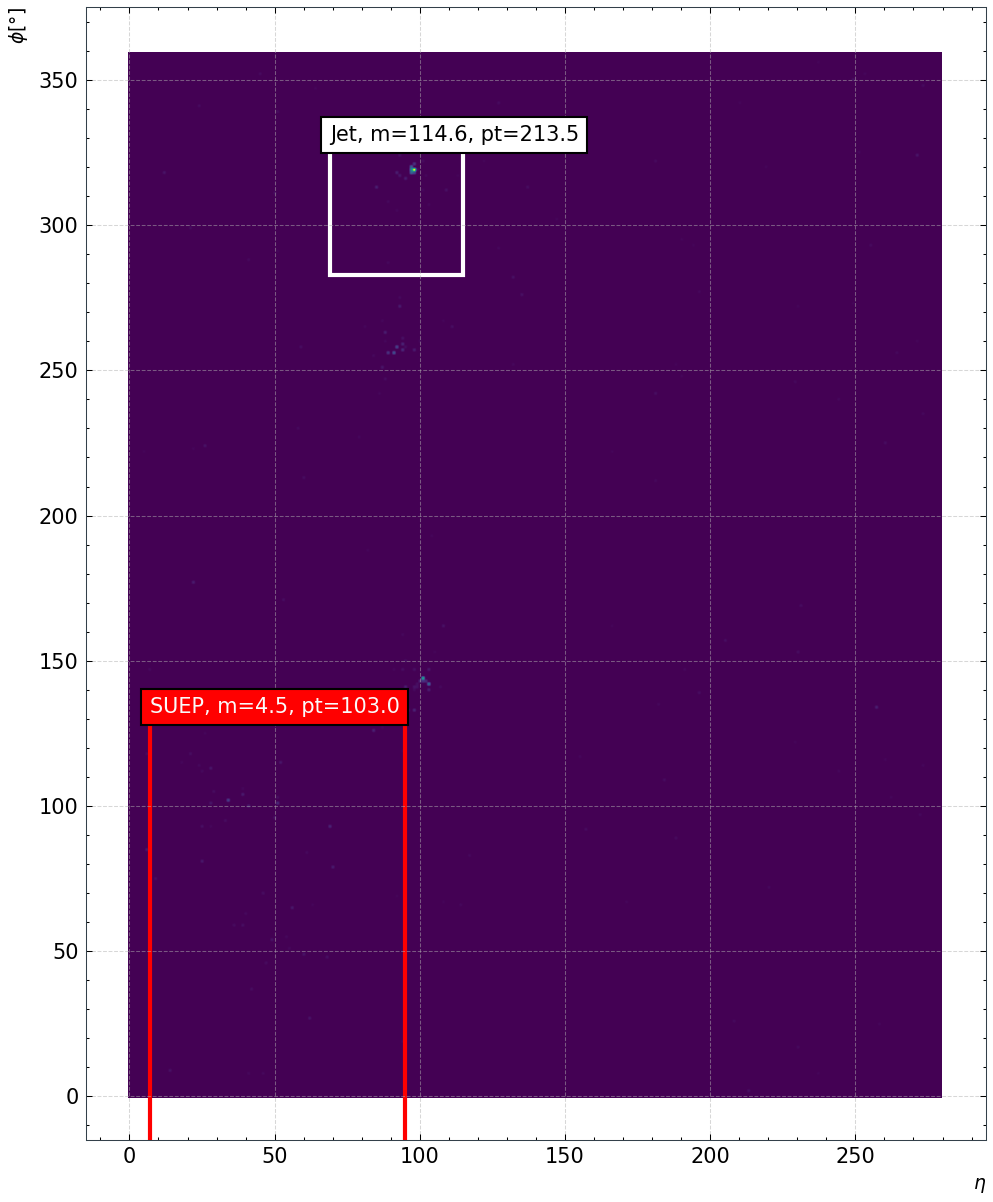

Event 5, ht=819.24
[0.825, 0.844, 0.833, -0.665, 0.856, -0.76, ... -0.195, 2.08, -0.407, -1.27, 2.34]


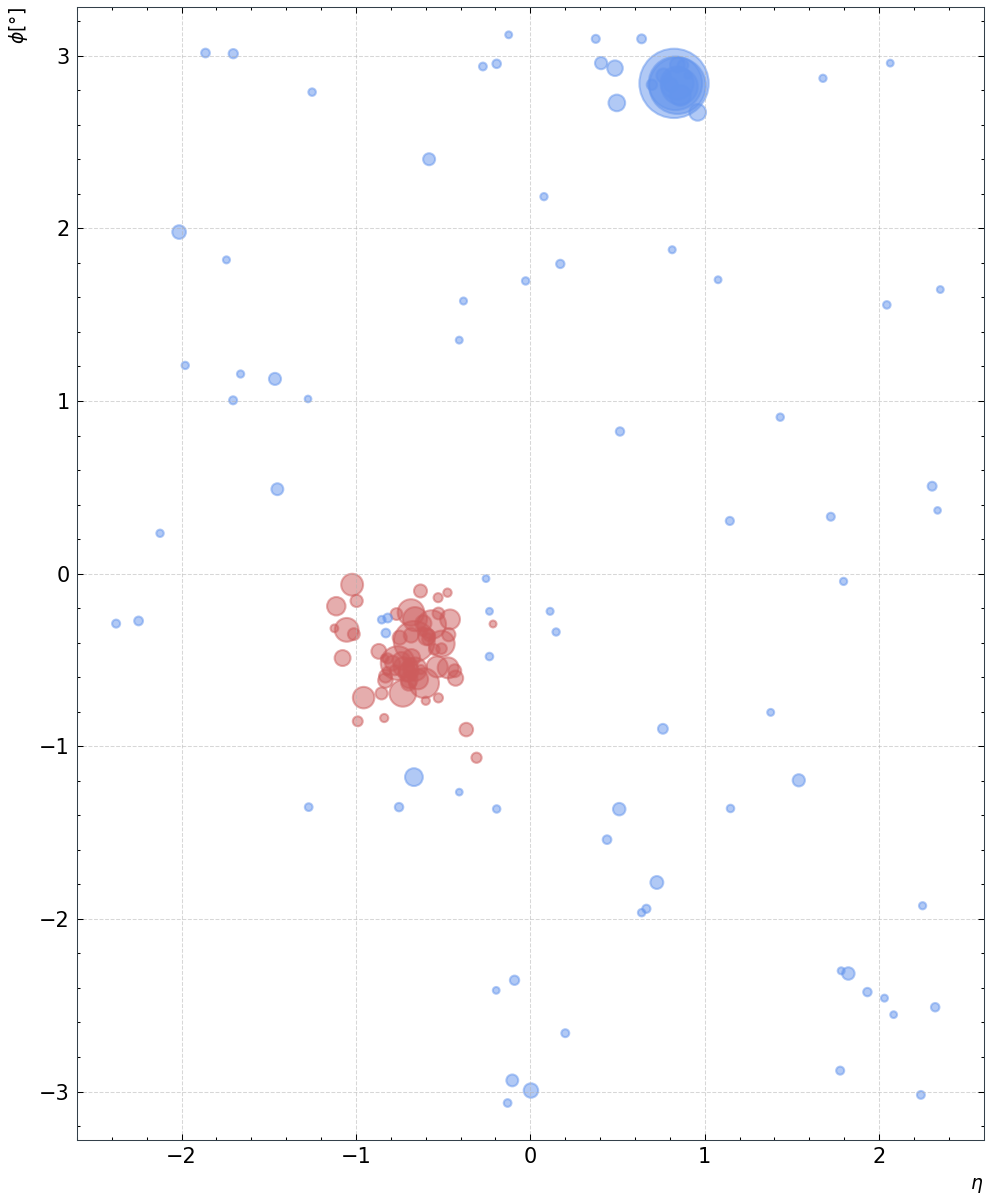

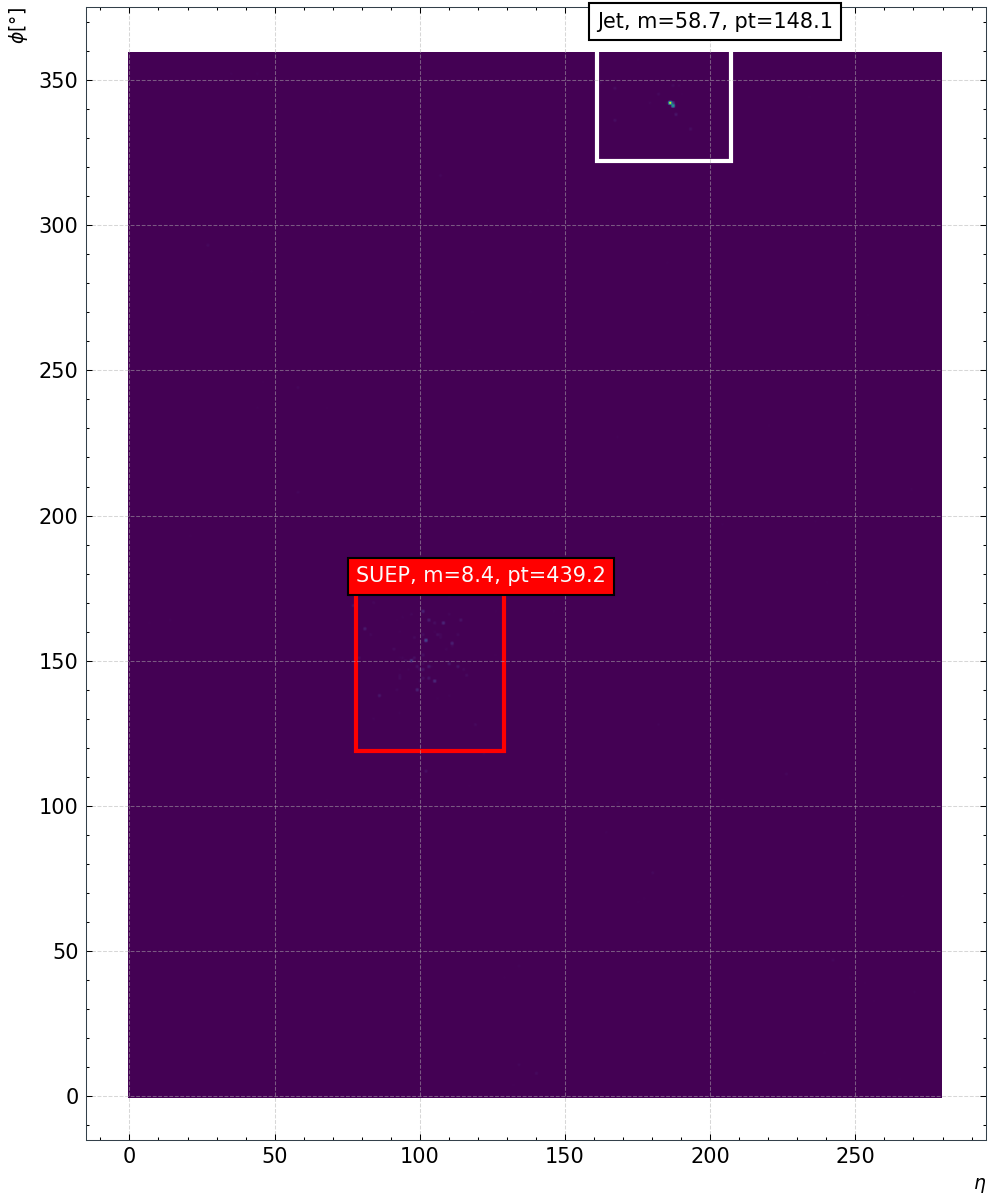

Event 6, ht=596.46
[2.39, 0.903, 1.78, 1.47, 1.31, 1.78, ... 1.06, 1.97, -0.704, 0.397, -0.473, 0.755]


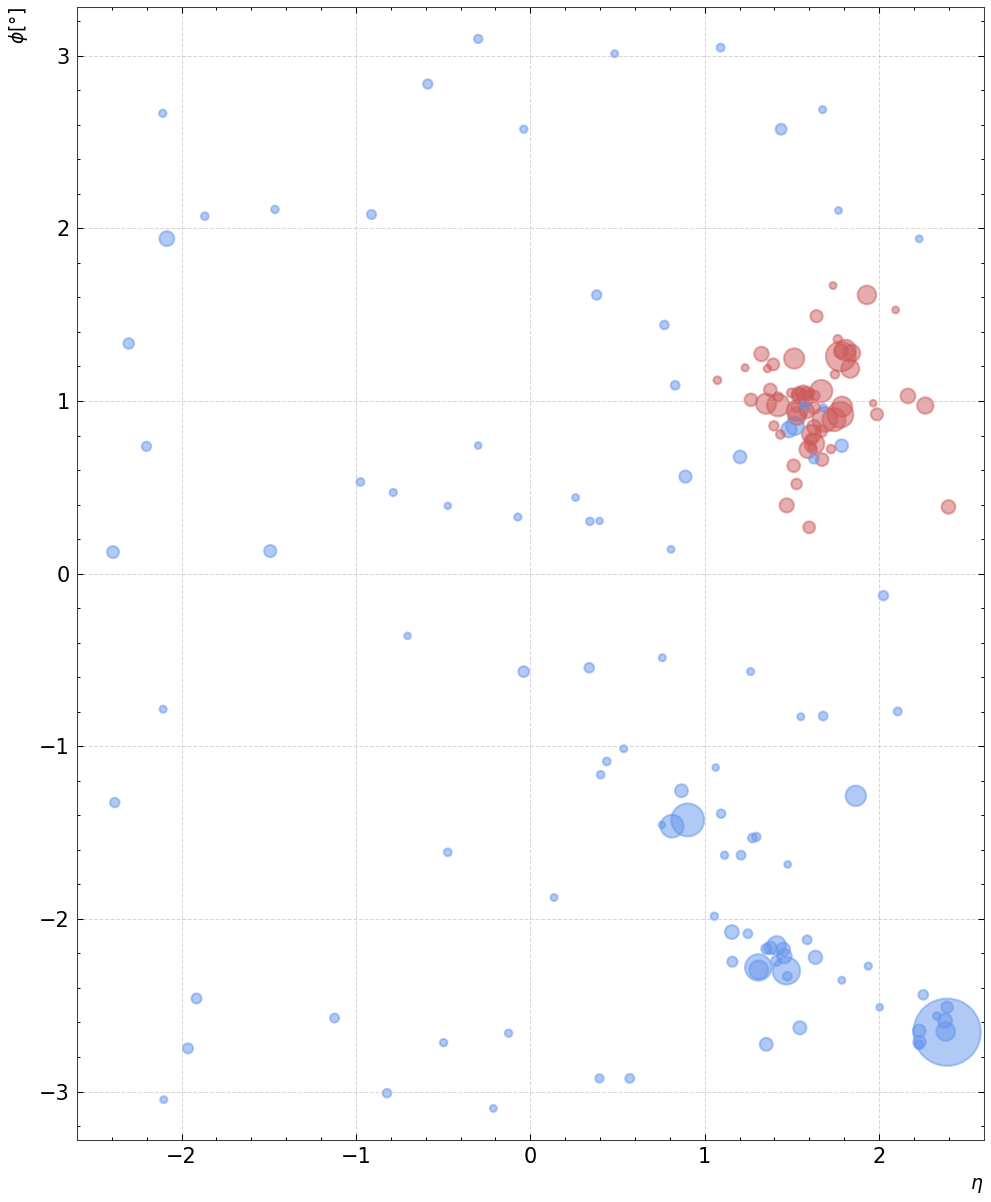

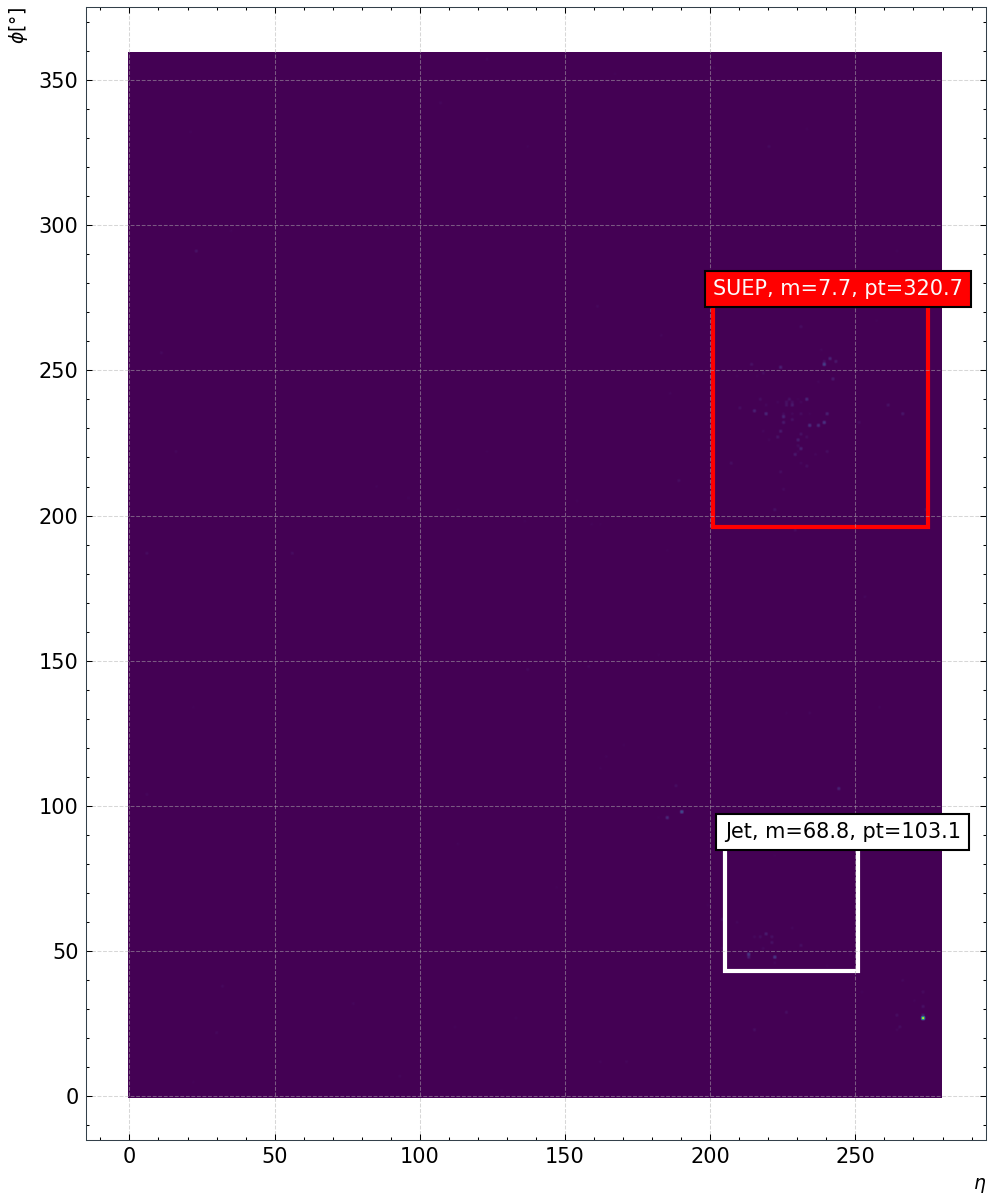

Event 7, ht=588.26
[0.744, -0.612, -2.05, 0.73, 0.748, 1.41, ... 1.27, -1.74, -2.38, -2.18, -2.14, 2.35]


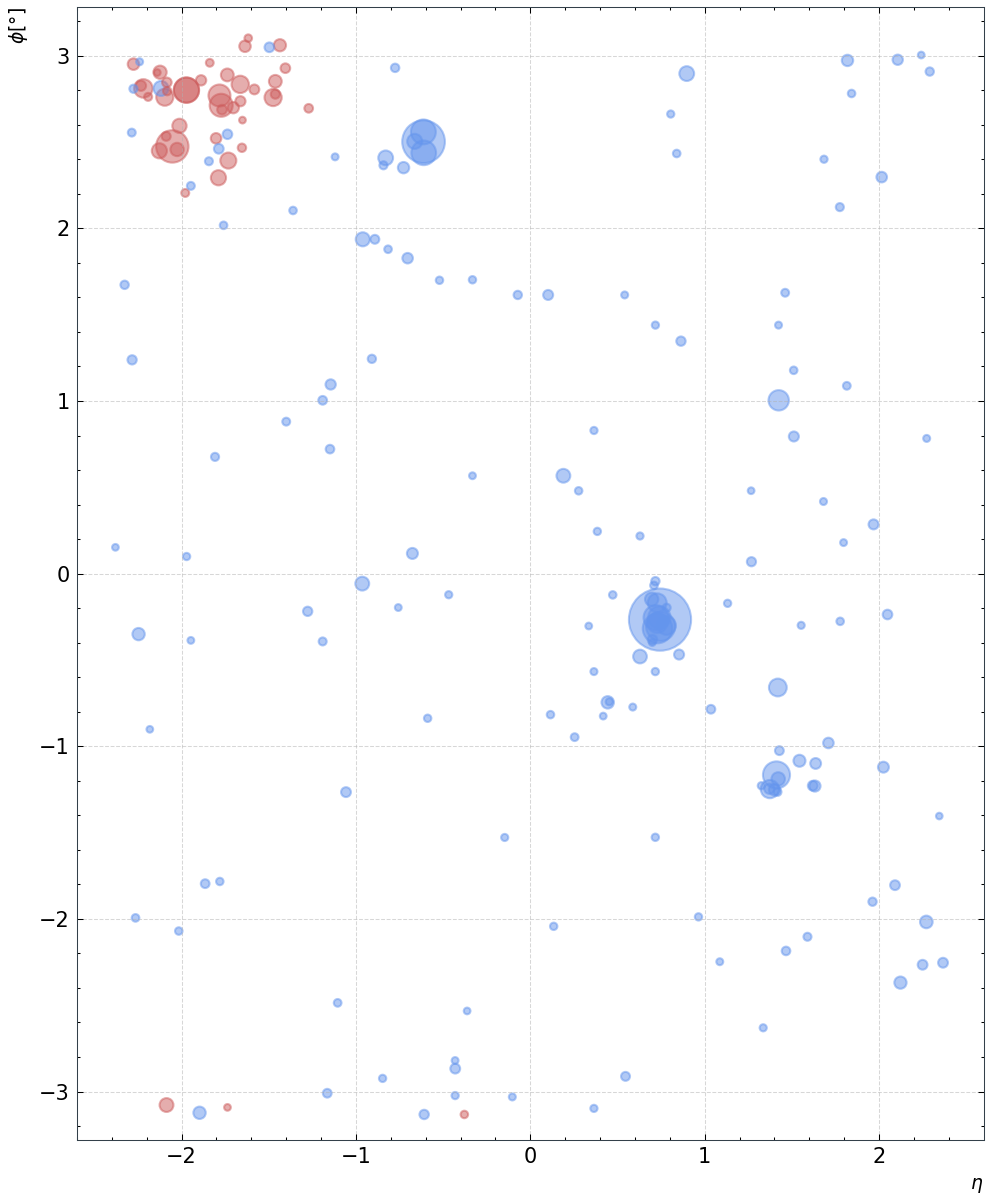

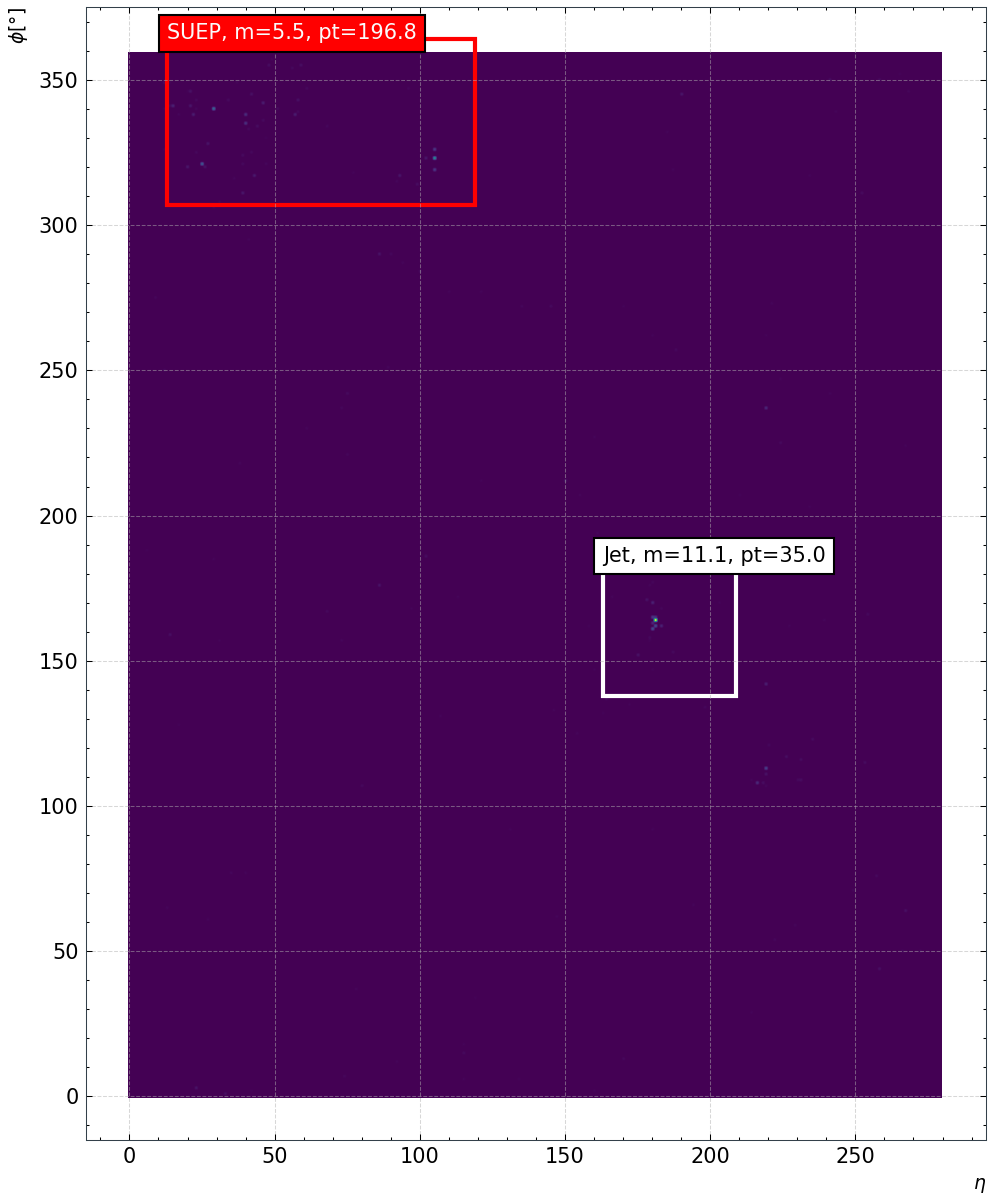

Event 8, ht=788.58
[0.88, 0.859, -0.103, -0.153, 0.8, 0.639, ... -0.723, -0.166, -0.334, -0.841, 0.814]


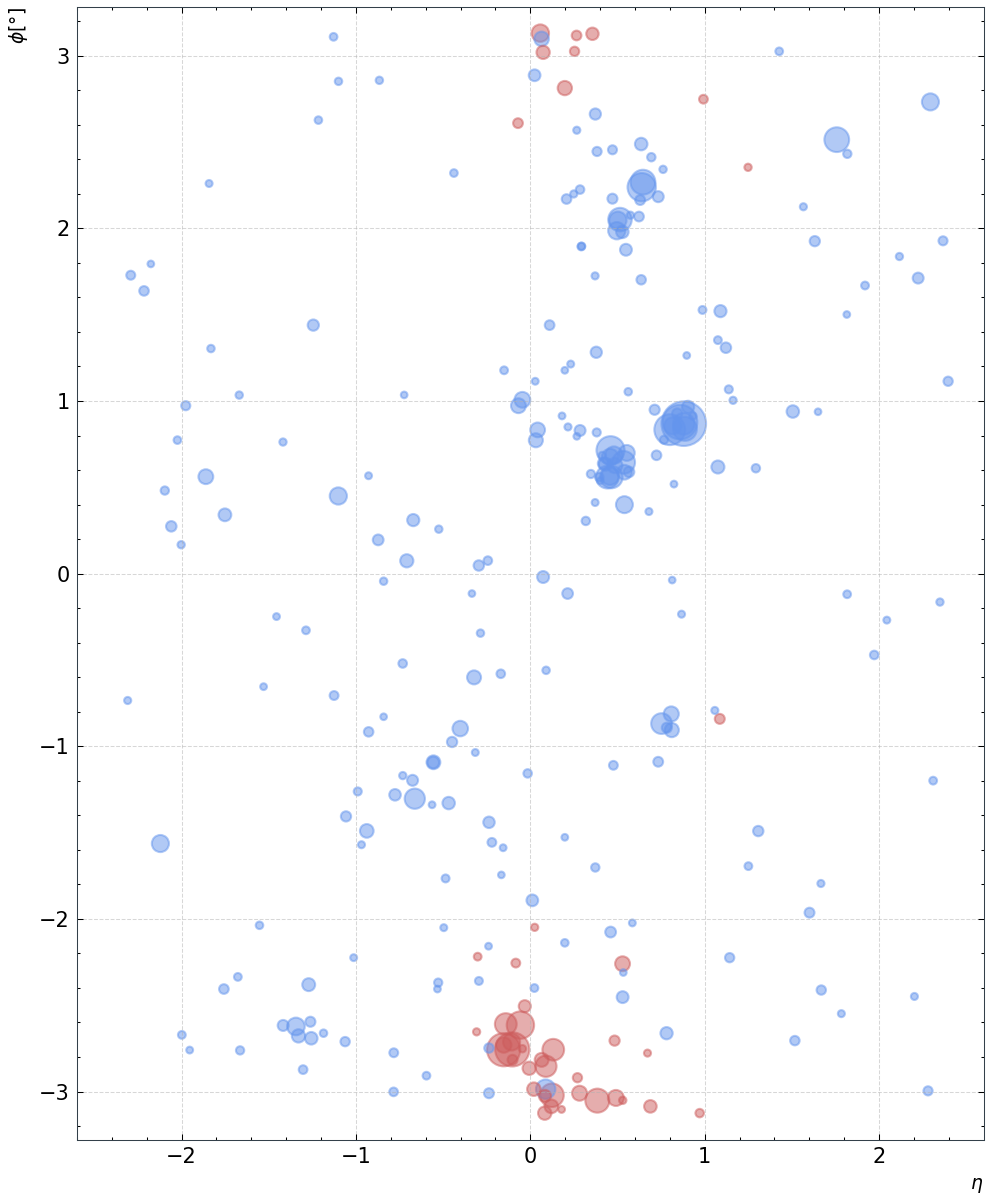

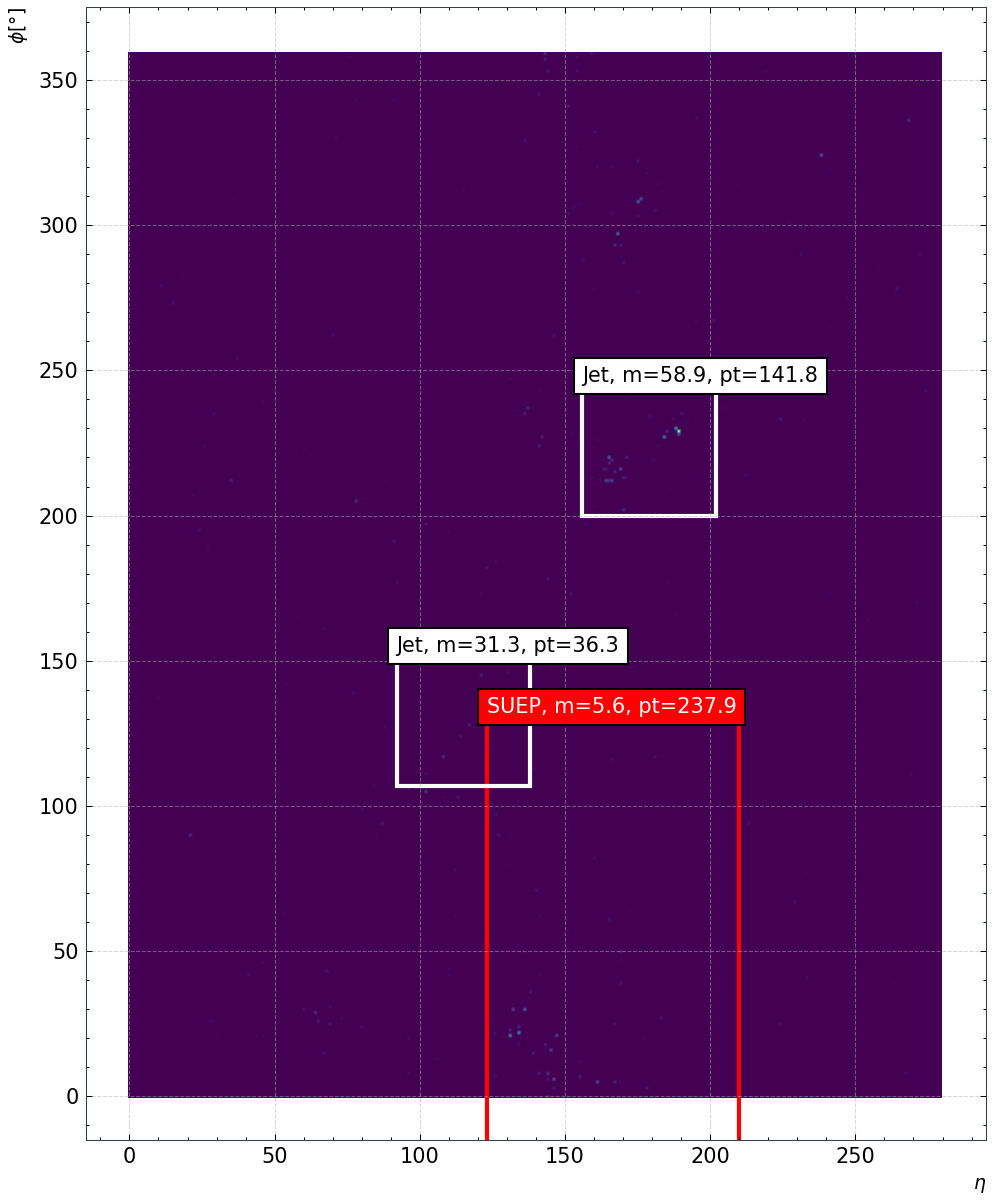

Event 9, ht=1058.29
[1.5, 1.86, 0.203, 1.65, 1.78, 0.283, ... -2.08, 0.305, -2.04, -0.569, 0.208, 1.54]


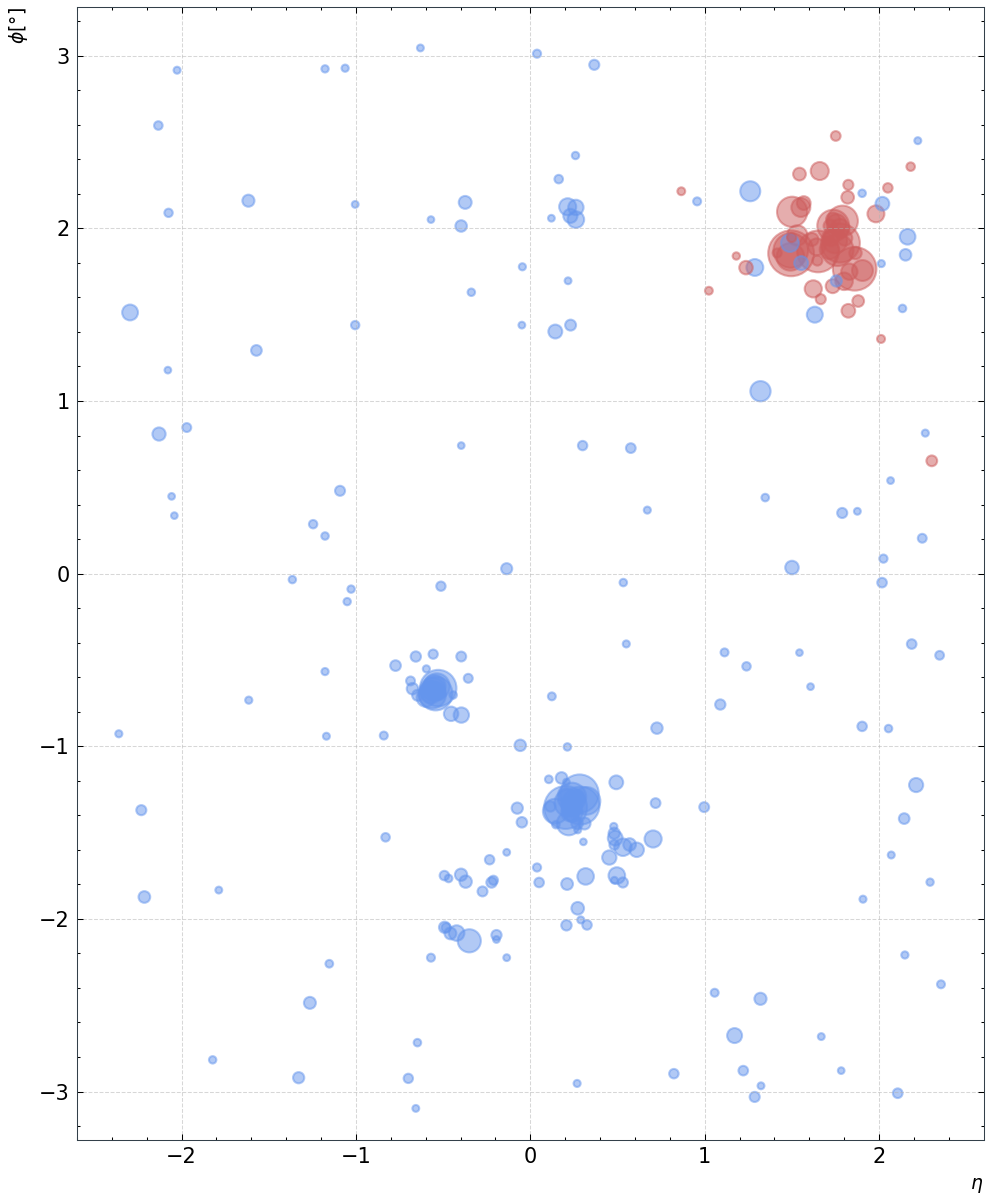

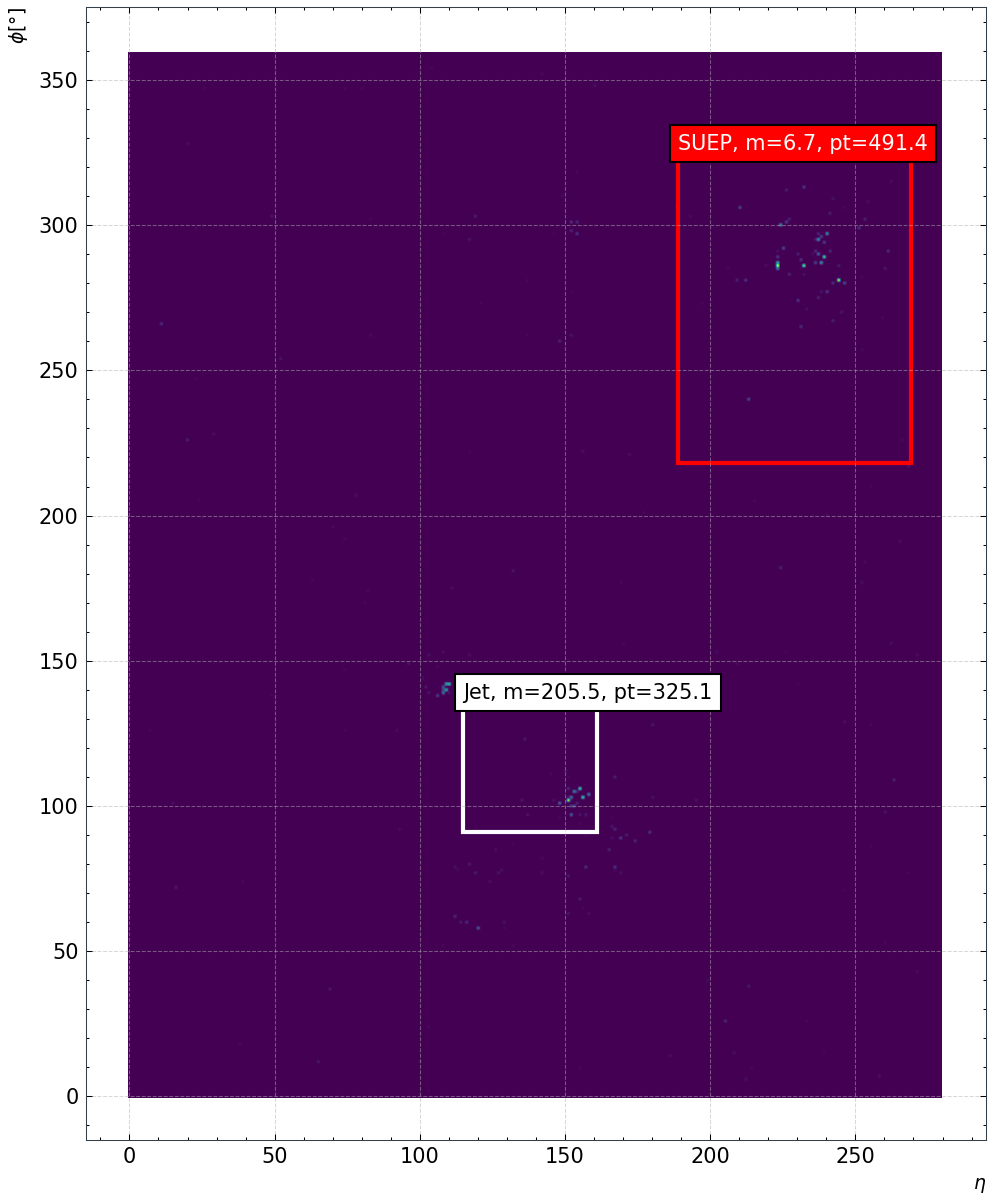

In [12]:
for i in range(10):

    # Sanity check
    if ht[i] < HT_THRESHOLD or n_fatjet[i] < 2:
        continue

    print('Event {}, ht={:.2f}'.format(i, ht[i]))

    xeta, xphi, _, img = get_energy_map(etas[i], phis[i], values[i])
    print(etas[i])
    label = get_suep_label(etas[i], phis[i], pts[i], mass[i], is_suep[i])
    jets = get_jet_labels(fatjet_eta[i], fatjet_phi[i], fatjet_pt[i], fatjet_mass[i], label)
    
    # Visualize the event
    plotEtaPhi(ak.to_numpy(etas[i]), ak.to_numpy(phis[i]), ak.to_numpy(values[i]), ak.to_numpy(is_suep[i]), True)
    
    # Final image with labels
    show_image(img.T, label, jets)